# This Python Notebook Implements an ARIMA model for Time Series Forecasting Renewable Energy Output

### First, we import our packages:

In [4]:
import h5py
import pandas as pd
# import s3fs
import matplotlib.pyplot as plt
import datetime
import math
import sklearn
from sklearn.metrics import mean_squared_error
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller



# Import Data:
## This ARIMA model is designed to be used for actual LOAD data on 5 minute intervals. Data files can be retrieved from:
https://data.openei.org/s3_viewer?bucket=arpa-e-perform&prefix=ERCOT%2F2018%2FLoad%2F


In [5]:
print(" 1 - Coast\n 2 - East\n 3 - Far West\n 4 - West\n 5 - North\n 6 - North Central\n 7 - South\n 8 - South Central")
filename = ""
while True:
    try:
        choice = int(input("Select a Region (1-8):"))
        break
    except:
        print("Invalid input.")
if choice == 1:
    filename = 'Data/Load/Zone_Coast_load_actuals_2018.h5'
elif choice == 2:
    filename = 'Data/Load/Zone_East_load_actuals_2018.h5'
elif choice == 3:
    filename = 'Data/Load/Zone_Far_West_load_actuals_2018.h5'
elif choice == 4:
    filename = 'Data/Load/Zone_West_load_actuals_2018.h5'
elif choice == 5:
    filename = 'Data/Load/Zone_North_load_actuals_2018.h5'
elif choice == 6:
    filename = 'Data/Load/Zone_North_Central_load_actuals_2018.h5'
elif choice == 7:
    filename = 'Data/Load/Zone_Southern_load_actuals_2018.h5'
elif choice == 8:
    filename = 'Data/Load/Zone_South_Central_load_actuals_2018.h5'
else:
    print("Invalid input.")


 1 - Coast
 2 - East
 3 - Far West
 4 - West
 5 - North
 6 - North Central
 7 - South
 8 - South Central


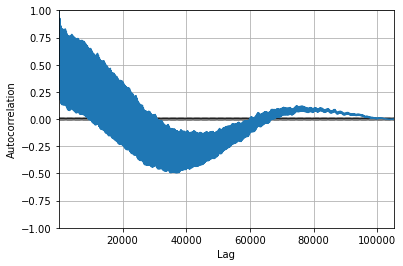

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

with h5py.File(filename, 'r') as f:
    actuals = pd.DataFrame(f['actuals'][...])
    # actual_time_steps = pd.to_datetime(f['time_index'][...].astype(str), errors='coerce', format='%Y-%m-%d %H:%M:%S')
    actuals['date'] = pd.to_datetime(f['time_index'][...].astype(str), errors='coerce', format='%Y-%m-%d %H:%M:%S')
    # dates = pd.DataFrame(f['time_index'][...].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
# df = pd.concat([actuals,actual_time_steps],axis = 1)
# autocorrelation_plot(actuals)
    actuals.columns = ['Load','Date']
    actuals = actuals.iloc[:,[1,0]]
    # print(actuals.head())
    # plt.plot(actuals['Date'], actuals['Load'])
    # plt.show()
    autocorrelation_plot(actuals['Load'])

## Allow user to input custom date range:

In [8]:
#X = actuals['Load']
startday = input("What day of the year would you like to start at (1-364)? ")
daysinintervals = int(startday) * 288;
numforecasts = input("How many periods would you like to forecast (ex> 12 periods = 1hr) ")


# half = int(len(actuals['Wind'])*0.5)
# full = int(len(actuals['Wind']))
# print(full)
# print(half)
train = actuals['Load'][(daysinintervals - 2016):daysinintervals] 
test = actuals['Load'][daysinintervals:daysinintervals+int(numforecasts)]
# print(test[52560], train)
history = [x for x in train]
expected = list()
predictions = list()
dates = list()
# print(test[52575])

## RUN ARIMA MODEL:

In [9]:
#Walk Forward Validation
# model = ARIMA(history, order=(1,1,1))
for t in range(daysinintervals,daysinintervals+int(numforecasts)):
    model = ARIMA(history, order=(2,1,2))
    # model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    # print(output)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    date = actuals['Date'][t]
    dates.append(date)
    date = date.strftime("%Y-%m-%d %H:%M:%S")
    history.append(test[t])
    expected.append(test[t])
    print('%d Date = %s, Predicted = %f, Expected = %f' % ((t-daysinintervals),date, yhat, obs))
#evaluate forecasts
output = pd.DataFrame([dates, expected, predictions])
with open('ModelOutput.csv', 'w') as csv_file:
        output.to_csv(csv_file, index = False)

0 Date = 2018-07-20 00:00:00, Predicted = 17431.588066, Expected = 17469.605469
1 Date = 2018-07-20 00:05:00, Predicted = 17438.524982, Expected = 17450.279297
2 Date = 2018-07-20 00:10:00, Predicted = 17417.969807, Expected = 17459.761719
3 Date = 2018-07-20 00:15:00, Predicted = 17447.778995, Expected = 17456.667969
4 Date = 2018-07-20 00:20:00, Predicted = 17439.275855, Expected = 17434.279297
5 Date = 2018-07-20 00:25:00, Predicted = 17415.400706, Expected = 17382.632812
6 Date = 2018-07-20 00:30:00, Predicted = 17348.647654, Expected = 17332.904297
7 Date = 2018-07-20 00:35:00, Predicted = 17299.098561, Expected = 17263.771484
8 Date = 2018-07-20 00:40:00, Predicted = 17214.334351, Expected = 17203.142578
9 Date = 2018-07-20 00:45:00, Predicted = 17156.728453, Expected = 17156.802734
10 Date = 2018-07-20 00:50:00, Predicted = 17111.159081, Expected = 17101.062500
11 Date = 2018-07-20 00:55:00, Predicted = 17050.691127, Expected = 17038.490234


## Graph Predictions:

Test RMSE: 23.057


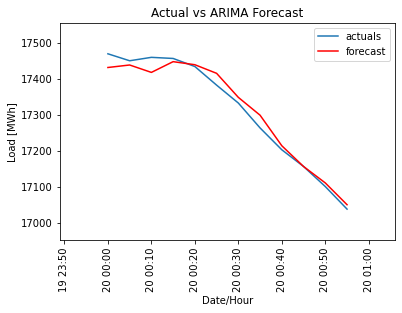

In [10]:
rmse = math.sqrt(sklearn.metrics.mean_squared_error(expected, predictions))
print('Test RMSE: %.3f' % rmse)
#plot forecasts against actual outcomes
plt.plot(dates,expected, label = "actuals")
plt.plot(dates,predictions, color = 'red', label = "forecast")
plt.xticks(rotation='vertical')
plt.margins(0.2)
plt.xlabel("Date/Hour")
plt.ylabel("Load [MWh]")
plt.title("Actual vs ARIMA Forecast")
plt.legend()
plt.show()

## Helper Functions:

### CSV converter:

In [ ]:
fpath = 'Data/ZoneCoastLoadActuals.csv'
with h5py.File('Zone_Coast_load_actuals_2018.h5', 'r') as f:
    filepath = Path('~/ZoneCoastLoadActual2018.csv')
    actuals = pd.DataFrame(f['actuals'][...])
    # actual_time_steps = pd.to_datetime(f['time_index'][...].astype(str), errors='coerce', format='%Y-%m-%d %H:%M:%S')
    actuals['date'] = pd.to_datetime(f['time_index'][...].astype(str), format='%Y-%m-%d %H:%M')
    actuals.columns = ['Load','Date']

    # actuals.to_csv(filepath, index = False)
    with open('ZoneCoastLoadActual2018.csv', 'w') as csv_file:
        actuals.to_csv(csv_file, index = False)


### PACF and ACF graphs for fitting model

In [ ]:

plot_pacf(train);
plot_acf(train);
ad_fuller_result = adfuller(train)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')